In [3]:
import pandas as pd
import os
import numpy as np
import sys
sys.path.append('..')

In [4]:
os.chdir(r'C:\Users\Administrator\Desktop\raphi_other\repositories\template_project\src')

In [155]:
data = pd.read_csv(r'../data/interim/cars_data.csv')

In [157]:
#test = pd.read_csv(r'../data/interim/test.csv')

In [160]:
columns_to_drop = ['article_id', 'created_date', 'deleted_date', 'ctr']#, 'SCC', 'SMOKE', 'FAVC', 'MTRANS']
data = data.drop(columns=columns_to_drop)

In [162]:
x = data.drop(columns=['product_tier'])
y = data.product_tier

In [164]:
# x['ctr'] = x['ctr'].astype('float64')

In [166]:
numerical_df = data.select_dtypes(exclude=['object'])
categorical_df = data.select_dtypes(include=['object'])

In [168]:
y

0        Basic
1        Basic
2        Basic
3        Basic
4        Basic
         ...  
70619    Basic
70620    Basic
70621    Basic
70622    Basic
70623    Basic
Name: product_tier, Length: 70624, dtype: object

In [170]:
#x.to_csv('../data/interim/house_xinit.csv', index=False)
#y.to_csv('../data/interim/house_yinit.csv', index=False)

In [172]:
#y.value_counts()

# Ordinal Encoding of y

In [175]:
order = ['Basic', 'Premium', 'Plus']#, 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

# Convert 'y' to a categorical type with the specified order
y = pd.Categorical(y, categories=order, ordered=True).codes

In [177]:
y = pd.Series(y, name='y')

In [99]:
y

0        0
1        0
2        0
3        0
4        0
        ..
70619    0
70620    0
70621    0
70622    0
70623    0
Name: y, Length: 70624, dtype: int8

In [179]:
numerical_df = x.select_dtypes(exclude=['object'])
categorical_df = x.select_dtypes(include=['object'])

In [181]:
numerical_df

,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days
0,16750,5,2013,3091.0,123.0,30
1,35950,4,2015,3283.0,223.0,52
2,1750,6,2003,1856.0,26.0,101
3,26500,3,2014,490.0,20.0,12
4,24890,6,2017,125.0,6.0,2
...,...,...,...,...,...,...
70619,3297,3,2008,604.0,34.0,4
70620,2950,6,2006,1175.0,16.0,25
70621,7850,8,2014,448.0,21.0,16
70622,13945,5,2011,1617.0,29.0,28


In [183]:
categorical_df

,make_name
0,Mitsubishi
1,Mercedes-Benz
2,Ford
3,Mercedes-Benz
4,Volkswagen
...,...
70619,Ford
70620,Hyundai
70621,Volkswagen
70622,Toyota


In [185]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in x.columns if x[cname].nunique() < 800 and x[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in x.columns if x[cname].dtype in ['int64', 'float64']]

In [187]:
categorical_cols

['make_name']

In [214]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler, MinMaxScaler

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [36]:
# X_train.to_csv('../data/interim/x_train_init.csv', index=False)
# X_test.to_csv('../data/interim/x_test_init.csv', index=False)
# y_train.to_csv('../data/interim/y_train_init.csv', index=False)
# y_test.to_csv('../data/interim/y_test_init.csv', index=False)

In [114]:
X_train.head()

,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days
46652,Volkswagen,7950,4,2011,5129.0,140.0,72
18143,Renault,6940,1,2012,344.0,12.0,23
30058,Kia,13945,5,2014,139.0,8.0,4
33137,Fiat,3495,5,2006,884.0,45.0,59
52540,Peugeot,9295,7,2014,1118.0,21.0,21


In [69]:
print(y_train)

937       32000000.0
9729     150000000.0
16861     85000000.0
9816      46000000.0
3459      40000000.0
            ...     
11964     65000000.0
21575     38000000.0
5390     120000000.0
860      160000000.0
15795    125000000.0
Name: y, Length: 16161, dtype: float64


In [89]:
#y_train = np.log(y_train)

In [101]:
#y_test = np.log(y_test)

In [116]:
print(y_train)

46652    0
18143    0
30058    0
33137    0
52540    0
        ..
37194    0
6265     0
54886    0
860      0
15795    0
Name: y, Length: 49436, dtype: int8


In [191]:
from category_encoders import BaseNEncoder

In [228]:
#create numerical transformer
numerical_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean')), 
                                  ('scaler', StandardScaler()) ])

#create categorical transformer
categorical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='most_frequent')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                            ])

target_encoding_pipeline = Pipeline(steps=[
    ('base_encoder', BaseNEncoder(cols=['make_name'], base=3))
])

In [218]:
# Combine the transformations using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('base_name', target_encoding_pipeline, ['make_name']),  # TargetEncoder for 'town'
    ('num', numerical_transformer, numerical_cols),       # Transformer for numerical columns
    ('cat_onehot', categorical_transformer, categorical_cols) # OneHotEncoder for other categorical features
])

In [220]:
# #column transformer
# preprocessor = ColumnTransformer(
#                                 transformers=[
#                                     ('num', numerical_transformer, numerical_cols),
#                                     ('cat', categorical_transformer, categorical_cols)
#     ])

In [231]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample

sampling_strategy = {
    0: y_train.value_counts()[0],  # Keep class 0 as is
    1: y_train.value_counts()[0],  # Oversample class 1 to the same as class 0
    2: y_train.value_counts()[0]   # Oversample class 2 to the same as class 0
}

# Example of undersampling
oversampler = RandomOverSampler(random_state=42, sampling_strategy=sampling_strategy)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [205]:
X_train.make_name.value_counts()

make_name
Volkswagen    18212
Renault       12267
Opel           9901
Peugeot        8945
Ford           8821
              ...  
DFSK              1
FISKER            1
Lincoln           1
Casalini          1
Kawasaki          1
Name: count, Length: 80, dtype: int64

In [151]:
# from imblearn.under_sampling import RandomUnderSampler

# # Example of undersampling
# undersampler = RandomUnderSampler(random_state=42, sampling_strategy='majority')
# X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [224]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a RandomForestClassifier model
rf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=5)

# Model pipeline
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('random_forest', rf)
                         ])

# Preprocessing of training data, fit model 
rf_pipe.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
rf_preds = rf_pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, rf_preds)
print('Accuracy for Random Forest Model:', accuracy)

# Detailed classification report
print('Classification Report:\n', classification_report(y_test, rf_preds))


Accuracy for Random Forest Model: 0.7180007551444214
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.84     20759
           1       0.08      0.56      0.14       333
           2       0.01      0.44      0.02        96

    accuracy                           0.72     21188
   macro avg       0.36      0.57      0.33     21188
weighted avg       0.98      0.72      0.82     21188



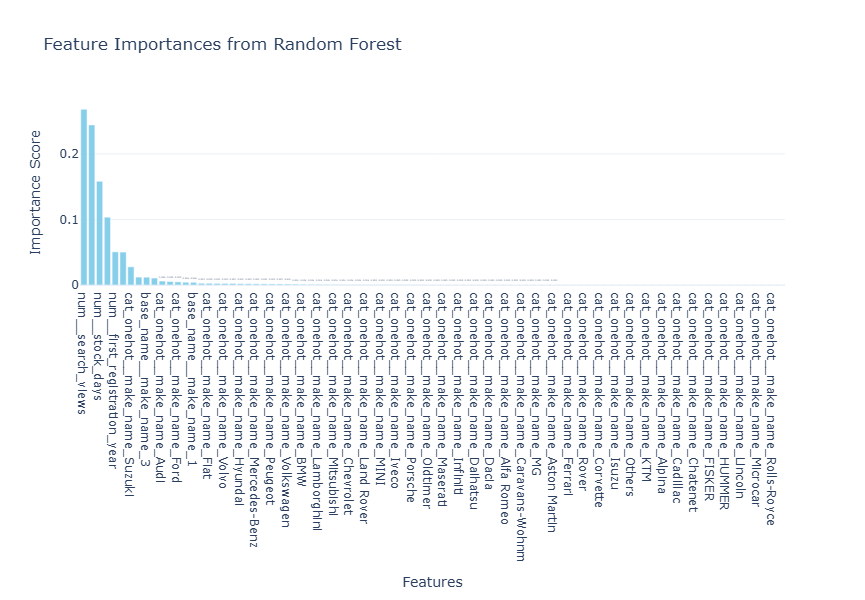

In [226]:
import plotly.graph_objects as go
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

importances = rf.feature_importances_

# Get the feature importances from the Random Forest model
# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(feature_names, importances))

# Optional: Sort the dictionary by importance in descending order
feature_importance_sorted = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

fig = go.Figure(data=[
        go.Bar(
            x=list(feature_importance_sorted.keys()),
            y=list(feature_importance_sorted.values()),
            marker=dict(color='skyblue'),
            text=[f"{v:.3f}" for v in feature_importance_sorted.values()],
            textposition='auto'
        )
    ])

# Update layout for better aesthetics
fig.update_layout(
    title='Feature Importances from Random Forest',
    xaxis_title='Features',
    yaxis_title="Importance Score",
    template='plotly_white',
    height=600
)

# Display the figure
fig.show()

In [ ]:
#show decision tree
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (80,40)
tree.plot_tree(rf,filled = True);
#plt.savefig('./images/tree_example.png')